In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
# copy code
!cp -r /content/drive/MyDrive/WASABI_gender_experiments/utils/reproduce_sexism_classifier/results .

In [34]:
%pylab inline
import pandas as pd
from collections import defaultdict
from scipy.stats import sem
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score

Populating the interactive namespace from numpy and matplotlib


In [6]:
# load data
results = pd.read_json("results/all_runs.json")
results

,train_domain,train_type,model_name,test_domain,test_type,y_test,y_pred_probas,y_pred,y_test_ids,macro avg precision,macro avg recall,macro avg f1-score,macro avg support,train,test
0,omnibus,adversarial,bert_finetuned,omnibus,adversarial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2113834172, 0.2743639946, 0.244562134100000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[2171.0, 1067.0, 2526.0, 2415.0, 1492.0, 7038....",0.809833,0.794020,0.791358,602,adversarial_bert_finetuned,omnibus_adversarial
1,omnibus,adversarial,bert_finetuned,omnibus,adversarial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.19726823270000002, 0.9034513831000001, 0.16...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...","[2668.0, 11416.0, 4823.0, 10043.0, 12929.0, 47...",0.793528,0.792359,0.792152,602,adversarial_bert_finetuned,omnibus_adversarial
2,omnibus,adversarial,bert_finetuned,omnibus,adversarial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4330096543, 0.2750335038, 0.272154033200000...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","[1401.0, 6096.0, 2261.0, 2167.0, 11784.0, 8755...",0.814826,0.812292,0.811914,602,adversarial_bert_finetuned,omnibus_adversarial
3,omnibus,adversarial,bert_finetuned,omnibus,adversarial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9020000100000001, 0.2777469158, 0.402097970...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[2425.0, 6182.0, 1830.0, 7850.0, 2170.0, 9058....",0.780743,0.780731,0.780728,602,adversarial_bert_finetuned,omnibus_adversarial
4,omnibus,adversarial,bert_finetuned,omnibus,adversarial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1882460564, 0.3071857691, 0.2187831998, 0.2...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[3428.0, 13274.0, 11329.0, 11768.0, 4051.0, 92...",0.808624,0.802326,0.801312,602,adversarial_bert_finetuned,omnibus_adversarial


### Compute scores

In [47]:
# error bar: standard error of the mean

performances = {}
thresholds = np.arange(0, 100, 2.5) / 100

score_names = ['Precision', 'Recall', 'Specificity', 'F1-score', 'Accuracy', 'Balanced Accuracy (adjusted)',
               'Precision (macro)', 'Recall (macro)', 'Specificity (macro)', 'F1-score (macro)']
metric_functions = [precision_score, recall_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score,
                    precision_score, recall_score, recall_score, f1_score]

for threshold in thresholds:

    # compute and store metrics
    performances[threshold] = defaultdict(list)

    for idx, row in results.iterrows():

        true_labels = np.array(row.y_test)
        pred_probas = np.array(row.y_pred_probas)
        pred_labels = (pred_probas > threshold).astype(int)

        for metric_func, metric_name in zip(metric_functions, score_names):

            if metric_name in ['Precision', 'Recall', 'Specificity', 'F1-score']:
                pos_label = 1 if metric_name!='Specificity' else 0
                score = metric_func(true_labels,
                                    pred_labels,
                                    pos_label=pos_label,
                                    zero_division=0,
                                    average='binary')
                
            elif metric_name in ['Precision (macro)', 'Recall (macro)', 'Specificity (macro)', 'F1-score (macro)']:
                #pos_label = 1 if metric_name!='Specificity (macro)' else 0
                score = metric_func(true_labels,
                                    pred_labels,
                                    zero_division=0,
                                    average='macro')

            elif metric_name=='Balanced Accuracy (adjusted)':
                score = metric_func(true_labels,
                                        pred_labels,
                                      adjusted=True)

            else:
                score = metric_func(true_labels,
                                        pred_labels)
                
            performances[threshold][metric_name].append(score)


Precision: 0.9132 at threshold 0.825
Recall: 1.0 at threshold 0.0
Specificity: 1.0 at threshold 0.95
F1-score: 0.8099 at threshold 0.45
Accuracy: 0.8027 at threshold 0.55
Balanced Accuracy (adjusted): 0.6053 at threshold 0.55
Precision (macro): 0.8049 at threshold 0.525
Recall (macro): 0.8027 at threshold 0.55
Specificity (macro): 0.8027 at threshold 0.55
F1-score (macro): 0.8024 at threshold 0.55


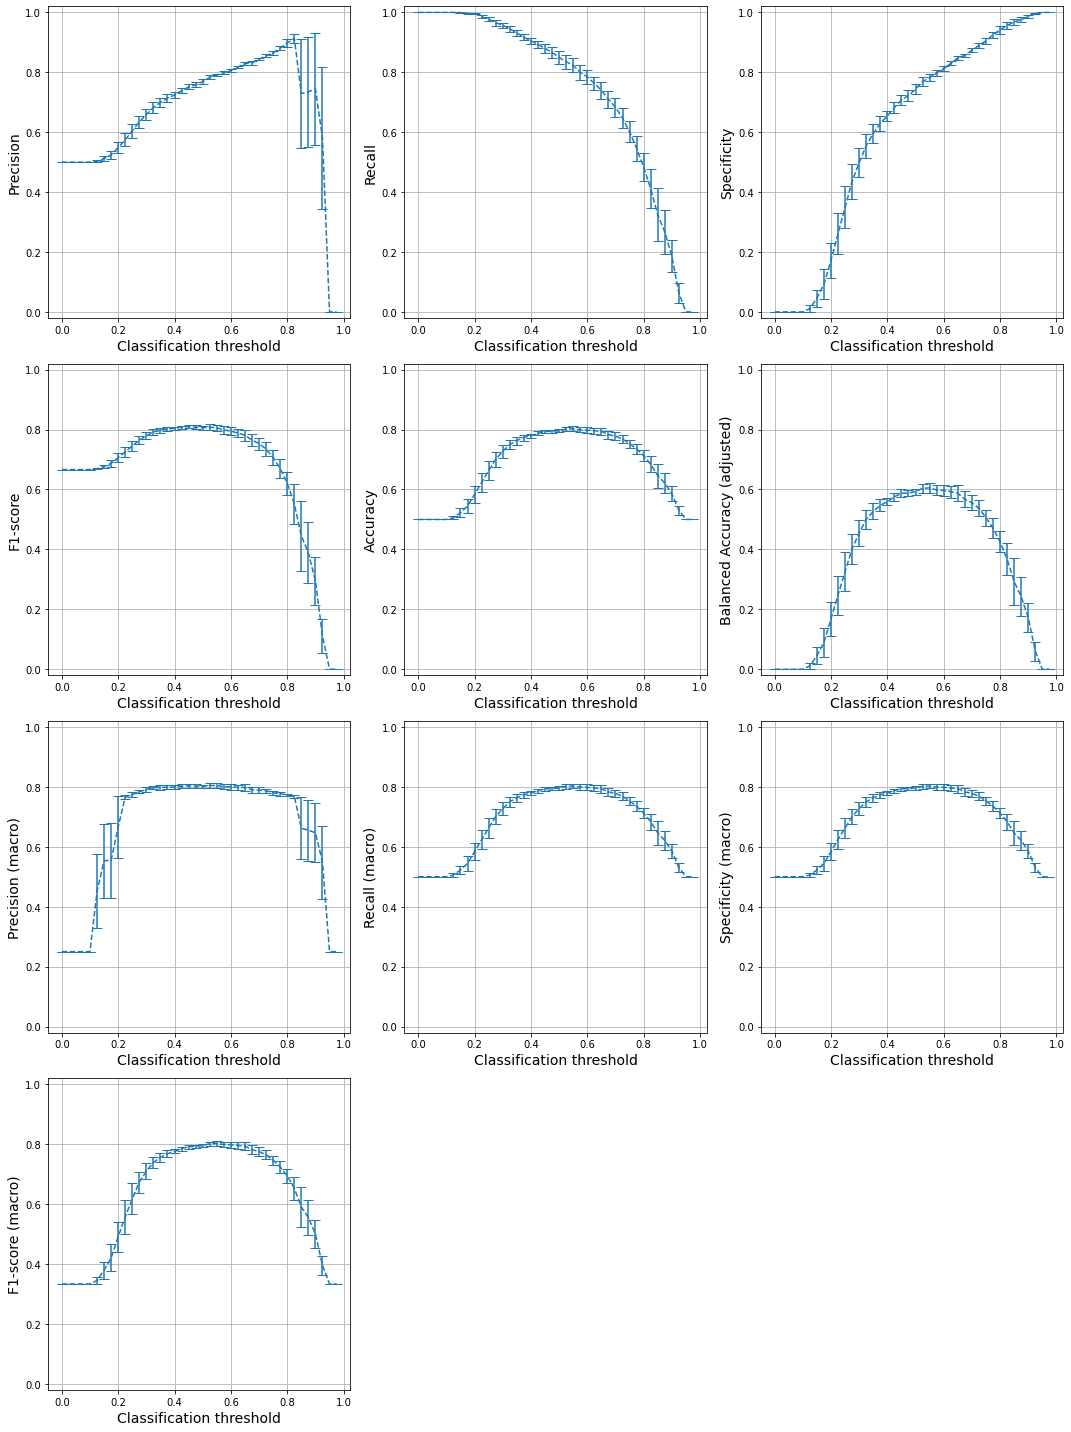

In [50]:
plt.figure(figsize=(15,20))

for n, score_name in enumerate(score_names, 1):

    plt.subplot(4,3,n)
    #plt.plot(thresholds, [performances[thr][score_name] for thr in thresholds])

    avg_scores = [np.mean(performances[thr][score_name]) for thr in thresholds]
    max_at = np.argmax(avg_scores)
    best_threshold = thresholds[max_at]

    plt.errorbar(thresholds, 
                 avg_scores,
                 yerr=[sem(performances[thr][score_name]) for thr in thresholds],
                 capsize=5,
                 ls='dashed')

    plt.xlabel('Classification threshold', fontsize=14)
    plt.ylabel(score_name, fontsize=14)
    plt.grid()
    plt.ylim(-0.02, 1.02)

    print(f'{score_name}: {round(max(avg_scores), 4)} at threshold {best_threshold}')

plt.tight_layout()